Task: “Apparently, the longer the customer browses our offer, the more often he buys something. If this is true, the sooner we find out that such a person is browsing our website, the better – consultants can then suggest something via chat.”

Definition of a business problem: determine which customers of a given online store need consultation.

In [56]:
# download data from GitHub repository
!git clone https://github.com/NastyaRush/UIM-21Z.git
!ls
%cd UIM-21Z/data/raw
!ls

Cloning into 'UIM-21Z'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 49 (delta 11), reused 32 (delta 5), pack-reused 0
Unpacking objects: 100% (49/49), done.
deliveries.jsonl  products.jsonl  sessions.jsonl  UIM-21Z  users.jsonl
/content/UIM-21Z/data/raw/UIM-21Z/data/raw
deliveries.jsonl  products.jsonl  sessions.jsonl  users.jsonl


In [57]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
sns.set();

In [58]:
# load data from files
df_products = pd.read_json('products.jsonl', lines=True)
df_sessions = pd.read_json('sessions.jsonl', lines=True)
df_users = pd.read_json('users.jsonl', lines=True)

In the "deliveries" file there is no data that will help in solving a given problem, so it has not been loaded.

In [59]:
# info about products
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [60]:
# info about users
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


In [61]:
# info about sessions
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56190 entries, 0 to 56189
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        56190 non-null  int64         
 1   timestamp         56190 non-null  datetime64[ns]
 2   user_id           56190 non-null  int64         
 3   product_id        56190 non-null  int64         
 4   event_type        56190 non-null  object        
 5   offered_discount  56190 non-null  int64         
 6   purchase_id       3935 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.0+ MB


There are null values ​​in the user_id, product_id and purchase_id columns. The purchase_id column will not be used for data analysis or modeling, so there is no need to do anything with missing values ​​in this column. Some null values ​​in the user_id column can be supplemented with values ​​from the session_id column because for the same session_id there will be the same user_id value. However, the gaps in the product_id column cannot be filled.

In [62]:
# before supplementing 'user_id'
df_sessions['user_id'].isnull().value_counts()
# True : represents the null values count
# False : represent the non-null values count

False    56190
Name: user_id, dtype: int64

In [63]:
# https://stackoverflow.com/questions/69004118/how-to-fill-missing-values-with-corresponding-values-from-other-rows
# create a dictionary that contains all session IDs and corresponding user IDs
users_sessions = df_sessions[['session_id', 'user_id', 'timestamp']].dropna().drop_duplicates()
df_sessions_updated = df_sessions[['session_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id']].merge(users_sessions, 'left')
users_sessions

,session_id,user_id,timestamp
0,124,102,2022-01-01 08:11:10
1,124,102,2022-01-01 08:13:51
2,124,102,2022-01-01 08:17:23
3,124,102,2022-01-01 08:19:22
4,124,102,2022-01-01 08:19:50
...,...,...,...
56185,9166,301,2022-01-04 17:20:23
56186,9166,301,2022-01-04 17:25:01
56187,9166,301,2022-01-04 17:26:45
56188,9166,301,2022-01-04 17:27:28


In [64]:
# https://stackoverflow.com/questions/34537048/how-to-count-nan-values-in-a-pandas-dataframe
# after supplementing 'user_id'
df_sessions_updated['user_id'].isnull().value_counts()
# True : represents the null values count
# False : represent the non-null values count

False    536470
Name: user_id, dtype: int64

In [65]:
# https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan
# removing rows with null user_id
df_sessions_updated = df_sessions_updated[df_sessions_updated['user_id'].notna()]
df_sessions_updated['user_id'].isnull().value_counts()

False    536470
Name: user_id, dtype: int64

Basing on the avaible customers data, two suggestions can be made:

1) the number of purchases is related to the amount of time that customers spent on the site

2) the number of purchases is related to the customer's city

In [66]:
# count number of purchase actions for each client
buy = df_sessions_updated.groupby('user_id')['event_type'].apply(lambda x: x[x == 'BUY_PRODUCT'].count())
df_buy = buy.to_frame().reset_index()
df_buy = df_buy.rename(columns={"event_type": "purchases_num"})
df_buy

,user_id,purchases_num
0,102,83
1,103,196
2,104,155
3,105,28
4,106,25
...,...,...
195,297,42
196,298,231
197,299,13
198,300,22


In [67]:
# https://stackoverflow.com/questions/16777570/calculate-time-difference-between-pandas-dataframe-indices
# time intervals between actions in individual sessions
users_sessions["timestamp_diff"] = users_sessions.groupby('session_id')["timestamp"].diff().apply(lambda x: x/np.timedelta64(1, 's')).fillna(0).astype('int64')
users_sessions

,session_id,user_id,timestamp,timestamp_diff
0,124,102,2022-01-01 08:11:10,0
1,124,102,2022-01-01 08:13:51,161
2,124,102,2022-01-01 08:17:23,212
3,124,102,2022-01-01 08:19:22,119
4,124,102,2022-01-01 08:19:50,28
...,...,...,...,...
56185,9166,301,2022-01-04 17:20:23,245
56186,9166,301,2022-01-04 17:25:01,278
56187,9166,301,2022-01-04 17:26:45,104
56188,9166,301,2022-01-04 17:27:28,43


In [68]:
# total sessions time for each user
sessions_time = users_sessions.groupby('user_id')["timestamp_diff"].sum()
df_sessions_time = sessions_time.to_frame().reset_index()
df_sessions_time

,user_id,timestamp_diff
0,102,24237
1,103,50914
2,104,36293
3,105,13059
4,106,21665
...,...,...
195,297,13807
196,298,68207
197,299,3402
198,300,11786


In [69]:
# calculate correlation between user's cities and the number of actions to purchase the product
df_users_cities = df_sessions_time.merge(df_users, on='user_id', how='inner')[["user_id", "timestamp_diff", "city"]]
column_1 = df_users_cities["timestamp_diff"]
column_2 = df_users_cities["city"].astype('category').cat.codes
correlation = column_1.corr(column_2)
correlation

0.03489690620419504

Correlation between the customer's city and the number of purchases is very low

In [70]:
# calculate correlation between the total time of browsing the website and the number of actions to purchase the product
input_data = pd.concat([df_sessions_time["timestamp_diff"], df_buy["purchases_num"]], axis=1)
column_1 = input_data["timestamp_diff"]
column_2 = input_data["purchases_num"]
correlation = column_1.corr(column_2)
correlation

0.956069214253588

But correlation between the time spent on the site and the number of purchases is big

In [71]:
# the amount of time spent on the site can be calculated in different ways (total time of browsing, number of sessions, number of 'view' event type), but the results of the correlation will be similar
sessions_number = users_sessions.groupby('user_id').session_id.nunique()
view = df_sessions.groupby('user_id')['event_type'].apply(lambda x: x[x == 'VIEW_PRODUCT'].count()) # VIEW_PRODUCT
df_view = view.to_frame().reset_index()
correlation = view.corr(buy)
print(correlation)
correlation = sessions_number.corr(buy)
print(correlation)

0.9530224147419194
0.946746793620433


In [72]:
# generation of random data (10 examples) similar to the tested ones and checking their correlation
random_examples_number = 20
max_sessions_time = input_data["timestamp_diff"].max()
max_buy = input_data["purchases_num"].max()
min_sessions_time = input_data["timestamp_diff"].min()
min_buy = input_data["purchases_num"].min()
input_data_len = len(input_data)
random_data_correlations = []
for _ in range(random_examples_number):
  data_values = []
  for _ in range(input_data_len):
    sessions_time_value = random.randint(min_sessions_time, max_sessions_time)
    buy_value = random.randint(min_buy, max_buy)
    data_values.append([sessions_time_value, buy_value])
  df_random_examples = pd.DataFrame(data_values, columns = ['timestamp_diff', 'purchases_num'])
  column_1 = df_random_examples["timestamp_diff"]
  column_2 = df_random_examples["purchases_num"]
  correlation = column_1.corr(column_2)
  random_data_correlations.append(correlation)
print(max([abs(i) for i in random_data_correlations]))

0.1406038564779797


The correlation of simular randomly generated data is much less, which means that the found dependence can be used for prediction

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


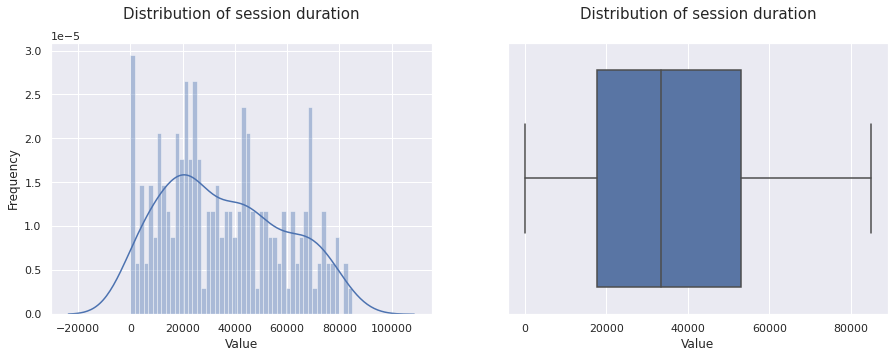

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(input_data["timestamp_diff"].values, bins=50)
plt.title('Distribution of session duration\n',fontsize=15)
plt.xlabel('Value'); plt.ylabel('Frequency');

plt.subplot(122)
sns.boxplot(input_data["timestamp_diff"].values)
plt.title('Distribution of session duration\n',fontsize=15)
plt.xlabel('Value'); 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


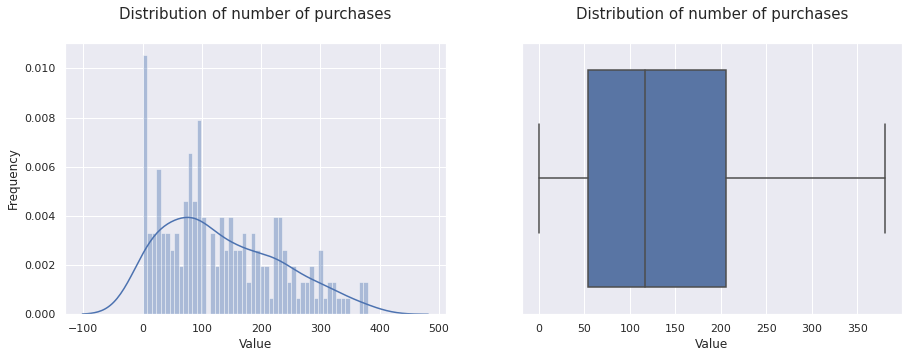

In [74]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(input_data["purchases_num"].values, bins=50)
plt.title('Distribution of number of purchases\n',fontsize=15)
plt.xlabel('Value'); plt.ylabel('Frequency');

plt.subplot(122)
sns.boxplot(input_data["purchases_num"].values)
plt.title('Distribution of number of purchases\n',fontsize=15)
plt.xlabel('Value'); 

The distribution plots show that there are no outliers in the variables, so there is no need to remove outliers

Normalize the target variable for better stability of the training process. Normalization will also help in solving the business problem, for example, we can accept that if the target variable value is above 0.5, the client needs a consultation, so this way we can easily rank customers

In [75]:
input_data["normalized_purchases_num"] = input_data["purchases_num"] /input_data["purchases_num"].abs().max()

In [76]:
X = input_data.timestamp_diff.to_numpy().reshape(-1, 1)
y = input_data.normalized_purchases_num.to_numpy()

In [77]:
# split data to train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=2)

Since there is a linear relationship in the data, we can use linear regression for prediction

In [78]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

#built the neural network architecture
model = Sequential()
model.add(Dense(40, input_dim=1, activation='relu'))
model.add(Dense(1, activation='linear'))

In [79]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [80]:
history = model.fit(X_train, y_train, epochs=80, validation_split=0.2)

Epoch 1/80
4/4 [==============================] - 1s 59ms/step - loss: 2421394.0000 - mse: 2421394.0000 - mae: 1283.1067 - val_loss: 707271.2500 - val_mse: 707271.2500 - val_mae: 722.0436
Epoch 2/80
4/4 [==============================] - 0s 9ms/step - loss: 296488.6875 - mse: 296488.6875 - mae: 397.9936 - val_loss: 5192.8750 - val_mse: 5192.8750 - val_mae: 61.8905
Epoch 3/80
4/4 [==============================] - 0s 10ms/step - loss: 120252.0703 - mse: 120252.0703 - mae: 255.9117 - val_loss: 347587.0000 - val_mse: 347587.0000 - val_mae: 506.2103
Epoch 4/80
4/4 [==============================] - 0s 17ms/step - loss: 409727.6562 - mse: 409727.6562 - mae: 540.0569 - val_loss: 379540.5938 - val_mse: 379540.5938 - val_mae: 528.9657
Epoch 5/80
4/4 [==============================] - 0s 9ms/step - loss: 294016.9062 - mse: 294016.9062 - mae: 451.1071 - val_loss: 106726.7188 - val_mse: 106726.7188 - val_mae: 280.5107
Epoch 6/80
4/4 [==============================] - 0s 16ms/step - loss: 49314.49

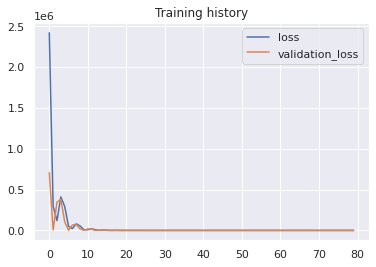

In [81]:
# plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.title('Training history')
plt.plot(history_df['loss'], label='loss')
plt.plot(history_df['val_loss'], label='validation_loss')
plt.legend()

In [82]:
# evaluate the model
model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 121ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0537


[0.005216642282903194, 0.005216642282903194, 0.053709857165813446]

2/2 [==============================] - 0s 5ms/step


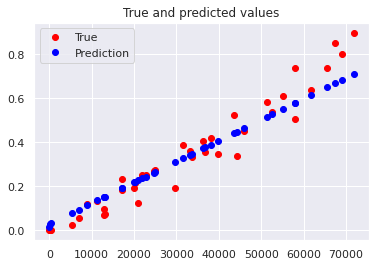

In [83]:
y_pred = model.predict(X_test).flatten()
plt.title('True and predicted values')
plt.plot(X_test.flatten(), y_test, "o", color="red", label='True')
plt.plot(X_test.flatten(), y_pred, "o", color="blue", label='Prediction')
plt.legend()

From the values ​​of the metrics, we can say that the constructed model performed well. Also from the graph above we can see that the model has caught the dependence in the data

Next, we can save the model and its weights and use them for making prediction directly in the business environment